# Optimizing an image to match a filter response
This notebook demonstrates using a Tensorflow convolution layer to match the filter response, based on a pre-defined kernel bank.

To get started, we set up logging and initialize Tensorflow.  Then we determine the location of the test image.

In [1]:
import sys, logging
log_format = '%(asctime)s | %(levelname)s : %(message)s'
logging.basicConfig(format=log_format, level=logging.INFO, stream=sys.stdout)

import tensorflow as tf
logging.info(f"Start with tf version {tf.version.VERSION}")

from pathlib import Path
racoon_path = (Path(os.environ['DATA_PHOTO_MISC']) / 'racoon').with_suffix('.png')
logging.info(f"Test image at {racoon_path}")

2022-03-01 14:58:45,498 | INFO : Start with tf version 2.8.0
2022-03-01 14:58:45,499 | INFO : Test image at G:\Data_Training_Photos\Misc\racoon.png


Now read the test raccoon (racoon) image and process it to make a tf tensor.  We will be using a 128x128 version of the image, to limit memory usage.  Show the result, to make suer that we have loaded the racoon correctly

2022-03-01 15:00:44,005 | INFO : Original size = (476, 476)
2022-03-01 15:00:44,014 | INFO : Setting size to 128: shape = (1, 128, 128, 1)


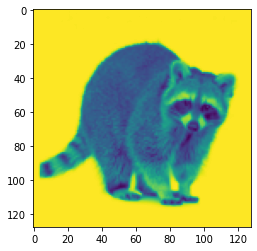

In [2]:
from imageio import imread
from skimage.color import rgb2gray
from common.image_ops import *

orig_racoon = imread(racoon_path)
orig_racoon = rgb2gray(orig_racoon)
logging.info(f"Original size = {orig_racoon.shape}")

sz = 128
racoon = resize_img(orig_racoon, sz=sz)
racoon = whiten_img(racoon)
racoon = np.reshape(racoon, (1,sz,sz,1))
logging.info(f"Setting size to {sz}: shape = {racoon.shape}")

import matplotlib.pyplot as plt
plt.imshow(tf.reshape(racoon[...,0], (racoon.shape[1], racoon.shape[2])))

### Generating the Model
The model is a one layer network with a square nonlinearity.  This emulates V1's response properties.

Start by generating the gabor kernel bank, with 13x13 kernels at 6 orientations at 3 spatial frequencies.

In [4]:
from common.filter_banks import *
ks = wave_numbers(6)
gabor_kernels = \
    make_gabor_kernels(sz=13, ks=ks, freqs=[0.5,1.0,2.0])
logging.info(f"Generated gabor kernels of size={gabor_kernels.shape}")

2022-03-01 15:01:04,542 | INFO : k=(0.0, 1.0) freq=0.5
2022-03-01 15:01:04,543 | INFO : k=(0.49999999999999994, 0.8660254037844387) freq=0.5
2022-03-01 15:01:04,544 | INFO : k=(0.8660254037844386, 0.5000000000000001) freq=0.5
2022-03-01 15:01:04,545 | INFO : k=(1.0, 6.123233995736766e-17) freq=0.5
2022-03-01 15:01:04,546 | INFO : k=(0.8660254037844387, -0.4999999999999998) freq=0.5
2022-03-01 15:01:04,546 | INFO : k=(0.49999999999999994, -0.8660254037844387) freq=0.5
2022-03-01 15:01:04,548 | INFO : k=(0.0, 1.0) freq=1.0
2022-03-01 15:01:04,549 | INFO : k=(0.49999999999999994, 0.8660254037844387) freq=1.0
2022-03-01 15:01:04,550 | INFO : k=(0.8660254037844386, 0.5000000000000001) freq=1.0
2022-03-01 15:01:04,550 | INFO : k=(1.0, 6.123233995736766e-17) freq=1.0
2022-03-01 15:01:04,551 | INFO : k=(0.8660254037844387, -0.4999999999999998) freq=1.0
2022-03-01 15:01:04,553 | INFO : k=(0.49999999999999994, -0.8660254037844387) freq=1.0
2022-03-01 15:01:04,553 | INFO : k=(0.0, 1.0) freq=2.0
2

Generate the matching output, which is the subsampled filter output from the racoon test image

In [5]:
racoon_input_tf = tf.constant(racoon, dtype=tf.float32)
racoon_out_sq = conv2d_sq(racoon_input_tf, gabor_kernels)

# add up the even and odd components
match_racoon_out_subsampled = tf.nn.max_pool(racoon_out_sq, (4,4), strides=2, padding='SAME')
logging.info(f"Shape of match_racoon_out_subsampled = {match_racoon_out_subsampled.shape}")

2022-03-01 15:01:09,611 | INFO : Shape of match_racoon_out_subsampled = (1, 64, 64, 18)


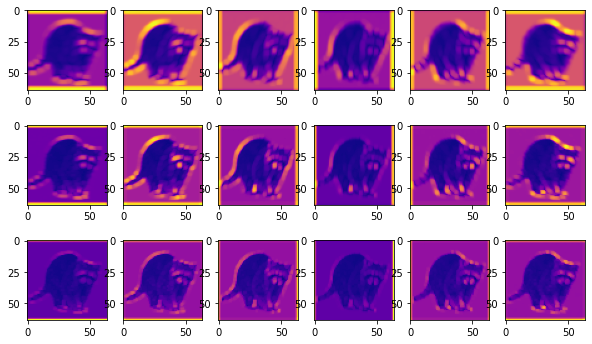

In [6]:
show_filter_response(match_racoon_out_subsampled, rows=3)

The loss function will be a mean-squared error match of the current tensor, filtered by the kernel bank, and then matched to the subsampled input.

In [7]:
def mse_loss_tf(current_tf:tf.Tensor, kernel_tf:tf.Tensor, matching_tf_subsampled:tf.Tensor):
    """mean-squared error loss function
    current_tf: tf.Tensor
        current tensor value
    kernel_tf: tf.Tensor
        the kernel bank to be used
    matching_tf_subsampled: tf.Tensor
        the subsampled match tensor

    returns: tf.Tensor
        a scalar tensor representing the loss
    """
    current_out_tf_sq = conv2d_sq(current_tf, kernel_tf)    
    current_out_tf_sub = tf.nn.max_pool(current_out_tf_sq, (4,4), strides=2, padding='SAME')    
    loss_per_level = tf.reduce_mean((current_out_tf_sub - matching_tf_subsampled) ** 2, axis=[0,1,2])
    
    # print(loss_per_level.shape)
    loss = tf.tensordot(loss_per_level, [8.] * 6 + [3.] * 6 + [1.] * 6, 1)
    return loss

# generate the current value as all 1s
current_value = tf.Variable(0.5 * np.ones((1,sz,sz,1)), dtype=tf.float32)

# and try out the mse_tf loss function
logging.info(mse_loss_tf(current_value, gabor_kernels, match_racoon_out_subsampled))

2022-03-01 15:02:02,591 | INFO : tf.Tensor(0.043101225, shape=(), dtype=float32)


To optimize, we are going to use a GradientTape to calculate the gradient w.r.t. the loss function.

We set up and perform one iteration to show how it is done.

2022-03-01 15:02:06,268 | INFO : Gradient max = 4.2316210056014825e-06


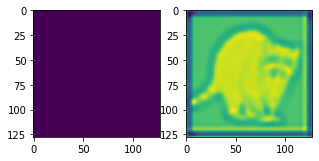

In [8]:
with tf.GradientTape() as tape:
    current_out = mse_loss_tf(current_value, gabor_kernels, match_racoon_out_subsampled)
grad = tape.gradient(current_out, current_value)
logging.info(f"Gradient max = {np.max(grad)}")

fig, axs = plt.subplots(1,2,figsize=(5,3))
axs[0].imshow(tf.reshape(current_value, (sz,sz)))
axs[1].imshow(tf.reshape(grad, (sz,sz)))

In [9]:
# learning_rate = 1e+3
optimizer = tf.optimizers.Adam()

print_output = 0
for n in range(1000):
    optimizer.apply_gradients(zip([grad], [current_value]))
    with tf.GradientTape() as tape:
        current_loss = mse_loss_tf(current_value, gabor_kernels, match_racoon_out_subsampled)
        print_output = (print_output+1) % 100
        if not print_output: tf.print(f"loss = {current_loss}")
    grad = tape.gradient(current_loss, current_value)

logging.info(f"Completed with final loss = {current_loss}")

loss = 0.029537051916122437
loss = 0.016454728320240974
loss = 0.008296226151287556
loss = 0.00475027272477746
loss = 0.0032755183055996895
loss = 0.002532582962885499
loss = 0.0020686096977442503
loss = 0.001722895773127675
loss = 0.0014435050543397665
loss = 0.0012056435225531459
2022-03-01 15:03:26,134 | INFO : Completed with final loss = 0.0012056435225531459


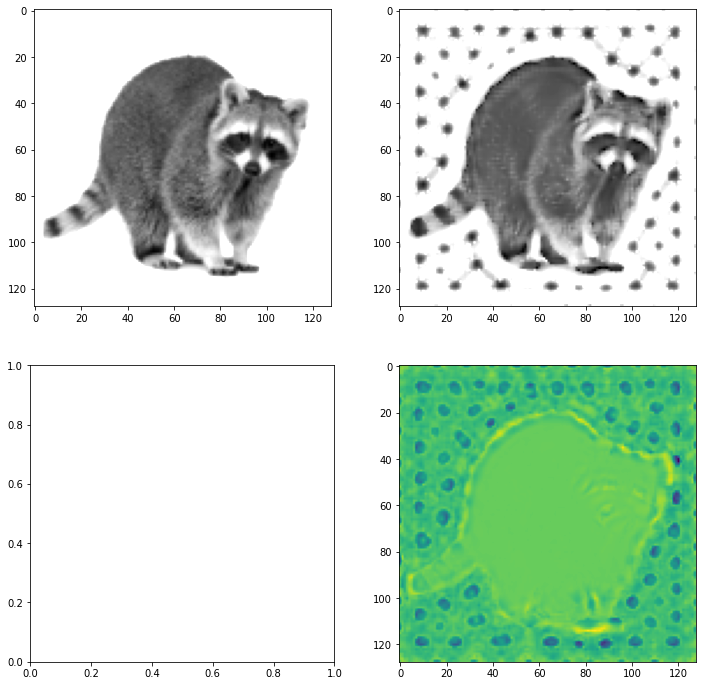

In [10]:
re_racoon = tf.reshape(current_value, (sz,sz))

fig, axs = plt.subplots(2,2,figsize=(12,12))
axs[0][0].imshow(tf.reshape(racoon[...,0], (sz,sz)), cmap='gray', vmin=0., vmax=0.8)
axs[0][1].imshow(re_racoon, cmap='gray', vmin=0., vmax=0.8)
axs[1][1].imshow(tf.reshape(grad, (sz,sz)))
plt.show()

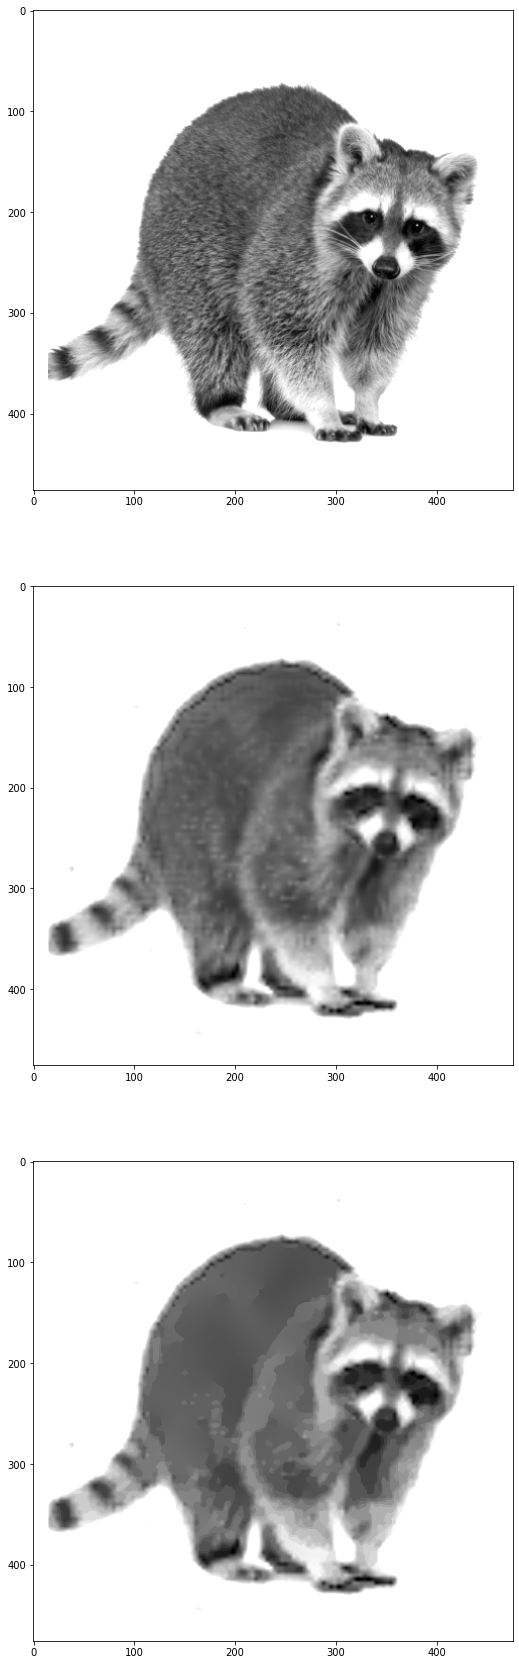

In [40]:
from skimage.transform import resize
re_racoon = resize(re_racoon, orig_racoon.shape)

import itk
diff_racoon = itk.gradient_anisotropic_diffusion_image_filter(re_racoon, 
                number_of_iterations=600,
                time_step=0.12,
                conductance_parameter=0.3,
                conductance_scaling_update_interval=1)

fig, axs = plt.subplots(3,1,figsize=(10,30))
axs[0].imshow(orig_racoon, cmap='gray', vmin=0., vmax=0.8)
axs[1].imshow(re_racoon, cmap='gray', vmin=0., vmax=0.8)
axs[2].imshow(diff_racoon, cmap='gray', vmin=0., vmax=0.8)